In [1]:
import numpy as np  
import matplotlib.pyplot as plt
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression, Ridge
import time

np.random.seed(42)

# Part 1: Data Generation
# Generate synthetic data with some multicollinearity
def generate_data(n_samples=200, n_features=20, noise=0.5, random_state=42):
   
    X, y = make_regression(n_samples=n_samples, 
                          n_features=n_features, 
                          n_informative=10,  # Only some features are informative
                          noise=noise, 
                          random_state=random_state)
    
    # Add some multicollinearity
    X[:, 5] = X[:, 0] + np.random.normal(0, 0.1, n_samples)
    X[:, 15] = 0.8 * X[:, 10] + 0.2 * X[:, 5] + np.random.normal(0, 0.1, n_samples)
    
    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=random_state)
    
    return X_train, X_test, y_train, y_test



In [2]:
# Part 2: Closed-form OLS Implementation
def ols_closed_form(X, y):
    """
    Compute Ordinary Least Squares solution using the closed-form expression:
    β = (X^T X)^(-1) X^T y
    
    Parameters:
    -----------
    X : ndarray of shape (n_samples, n_features)
        Feature matrix
    y : ndarray of shape (n_samples,)
        Target vector
        
    Returns:
    --------
    beta : ndarray of shape (n_features,)
        OLS coefficients
    """
    # Add a column of ones for the intercept
    X_with_intercept = np.column_stack((np.ones(X.shape[0]), X))
    
    # Compute (X^T X)^(-1) X^T y
    XTX = X_with_intercept.T @ X_with_intercept
    XTX_inv = np.linalg.inv(XTX)
    XTy = X_with_intercept.T @ y
    beta = XTX_inv @ XTy
    
    return beta



In [3]:
# Part 3: Closed-form Ridge Regression Implementation
def ridge_closed_form(X, y, lambda_):
    """
    Compute Ridge Regression solution using the closed-form expression:
    β = (X^T X + λI)^(-1) X^T y
    
    Parameters:
    -----------
    X : ndarray of shape (n_samples, n_features)
        Feature matrix
    y : ndarray of shape (n_samples,)
        Target vector
    lambda_ : float
        Regularization parameter
        
    Returns:
    --------
    beta : ndarray of shape (n_features,)
        Ridge regression coefficients
    """
    # Add a column of ones for the intercept
    X_with_intercept = np.column_stack((np.ones(X.shape[0]), X))
    n_features = X_with_intercept.shape[1]
    
    # Create identity matrix and set first element to 0 to avoid penalizing intercept
    I = np.eye(n_features)
    I[0, 0] = 0
    
    # Compute (X^T X + λI)^(-1) X^T y
    XTX = X_with_intercept.T @ X_with_intercept
    reg_matrix = XTX + lambda_ * I
    reg_matrix_inv = np.linalg.inv(reg_matrix)
    XTy = X_with_intercept.T @ y
    beta = reg_matrix_inv @ XTy
    
    return beta



In [4]:
# Part 4: Gradient Descent for OLS
def ols_gradient_descent(X, y, learning_rate=0.01, max_iterations=10000, tol=1e-6):
    """
    Implement gradient descent for OLS.
    
    Parameters:
    -----------
    X : ndarray of shape (n_samples, n_features)
        Feature matrix
    y : ndarray of shape (n_samples,)
        Target vector
    learning_rate : float
        Step size (c in the notes)
    max_iterations : int
        Maximum number of iterations
    tol : float
        Tolerance for convergence
        
    Returns:
    --------
    beta : ndarray of shape (n_features,)
        OLS coefficients
    loss_history : list
        History of loss values during iterations
    """
    # Add a column of ones for the intercept
    X_with_intercept = np.column_stack((np.ones(X.shape[0]), X))
    n_samples, n_features = X_with_intercept.shape
    
    # Initialize beta
    beta = np.zeros(n_features)
    
    # Store loss history
    loss_history = []
    
    # Gradient descent iterations
    for k in range(max_iterations):
        # Predict
        y_pred = X_with_intercept @ beta
        
        # Compute loss (MSE)
        loss = np.mean((y_pred - y) ** 2)
        loss_history.append(loss)
        
        # Compute gradient: ∇L = (2/n) * X^T * (X*β - y)
        gradient = (2 / n_samples) * X_with_intercept.T @ (y_pred - y)
        
        # Update beta: β(k+1) = β(k) - c * ∇L
        beta_new = beta - learning_rate * gradient
        
        # Check for convergence
        if np.linalg.norm(beta_new - beta) < tol:
            print(f"Converged after {k+1} iterations")
            break
            
        beta = beta_new
        
        # If we're not progressing, break
        if k > 1 and abs(loss_history[-1] - loss_history[-2]) < tol:
            print(f"Loss convergence after {k+1} iterations")
            break
            
    return beta, loss_history



In [5]:
# Part 5: Gradient Descent with Weight Decay (equivalent to Ridge Regression)
def weight_decay_gradient_descent(X, y, lambda_, learning_rate=0.01, max_iterations=10000, tol=1e-6):
    """
    Implement gradient descent with weight decay for Ridge Regression.
    
    Parameters:
    -----------
    X : ndarray of shape (n_samples, n_features)
        Feature matrix
    y : ndarray of shape (n_samples,)
        Target vector
    lambda_ : float
        Weight decay parameter (ω in the notes)
    learning_rate : float
        Step size (c in the notes)
    max_iterations : int
        Maximum number of iterations
    tol : float
        Tolerance for convergence
        
    Returns:
    --------
    beta : ndarray of shape (n_features,)
        Ridge regression coefficients
    loss_history : list
        History of loss values during iterations
    """
    # Add a column of ones for the intercept
    X_with_intercept = np.column_stack((np.ones(X.shape[0]), X))
    n_samples, n_features = X_with_intercept.shape
    
    # Initialize beta
    beta = np.zeros(n_features)
    
    # Store loss history
    loss_history = []
    
    # Gradient descent iterations with weight decay
    for k in range(max_iterations):
        # Predict
        y_pred = X_with_intercept @ beta
        
        # Compute loss (MSE + L2 regularization term)
        # Don't penalize intercept (beta[0])
        mse = np.mean((y_pred - y) ** 2)
        regularization = lambda_ * np.sum(beta[1:] ** 2)  # Skip intercept
        loss = mse + regularization
        loss_history.append(loss)
        
        # Compute gradient: ∇L = (2/n) * X^T * (X*β - y)
        gradient = (2 / n_samples) * X_with_intercept.T @ (y_pred - y)
        
        # Prepare weight decay term: ω * β
        decay = np.zeros_like(beta)
        decay[1:] = lambda_ * beta[1:]  # Skip intercept
        
        # Update beta: β(k+1) = β(k) - c * ∇L - ω * β(k)
        beta_new = beta - learning_rate * gradient - learning_rate * decay
        
        # Check for convergence
        if np.linalg.norm(beta_new - beta) < tol:
            print(f"Converged after {k+1} iterations")
            break
            
        beta = beta_new
        
        # If we're not progressing, break
        if k > 1 and abs(loss_history[-1] - loss_history[-2]) < tol:
            print(f"Loss convergence after {k+1} iterations")
            break
            
    return beta, loss_history



In [ ]:
# Part 6: Empirical demonstration of the equivalence of OLS+Weight Decay and Ridge Regression
def compare_methods(X_train, X_test, y_train, y_test):
    results = {}
    
    # 1. Sklearn OLS (LinearRegression)
    start_time = time.time()
    sklearn_ols = LinearRegression().fit(X_train, y_train)
    y_pred_ols_sklearn = sklearn_ols.predict(X_test)
    mse_ols_sklearn = mean_squared_error(y_test, y_pred_ols_sklearn)
    time_ols_sklearn = time.time() - start_time
    results['OLS (sklearn)'] = {'MSE': mse_ols_sklearn, 'Time': time_ols_sklearn}
    
    # 2. OLS Closed Form
    start_time = time.time()
    beta_ols = ols_closed_form(X_train, y_train)
    X_test_with_intercept = np.column_stack((np.ones(X_test.shape[0]), X_test))
    y_pred_ols_closed = X_test_with_intercept @ beta_ols
    mse_ols_closed = mean_squared_error(y_test, y_pred_ols_closed)
    time_ols_closed = time.time() - start_time
    results['OLS (closed form)'] = {'MSE': mse_ols_closed, 'Time': time_ols_closed}
    
    # 3. OLS Gradient Descent
    start_time = time.time()
    beta_ols_gd, loss_history_ols = ols_gradient_descent(X_train, y_train)
    y_pred_ols_gd = X_test_with_intercept @ beta_ols_gd
    mse_ols_gd = mean_squared_error(y_test, y_pred_ols_gd)
    time_ols_gd = time.time() - start_time
    results['OLS (gradient descent)'] = {'MSE': mse_ols_gd, 'Time': time_ols_gd, 'Loss History': loss_history_ols}
    
    # Try different lambda values for Ridge methods
    lambda_values = [0.1, 1, 10, 100]
    
    for lambda_ in lambda_values:
        # 4. Sklearn Ridge
        start_time = time.time()
        sklearn_ridge = Ridge(alpha=lambda_).fit(X_train, y_train)
        y_pred_ridge_sklearn = sklearn_ridge.predict(X_test)
        mse_ridge_sklearn = mean_squared_error(y_test, y_pred_ridge_sklearn)
        time_ridge_sklearn = time.time() - start_time
        results[f'Ridge (sklearn, λ={lambda_})'] = {'MSE': mse_ridge_sklearn, 'Time': time_ridge_sklearn}
        
        # 5. Ridge Closed Form
        start_time = time.time()
        beta_ridge = ridge_closed_form(X_train, y_train, lambda_)
        y_pred_ridge_closed = X_test_with_intercept @ beta_ridge
        mse_ridge_closed = mean_squared_error(y_test, y_pred_ridge_closed)
        time_ridge_closed = time.time() - start_time
        results[f'Ridge (closed form, λ={lambda_})'] = {'MSE': mse_ridge_closed, 'Time': time_ridge_closed}
        
        # 6. Ridge via Weight Decay
        start_time = time.time()
        beta_weight_decay, loss_history_wd = weight_decay_gradient_descent(X_train, y_train, lambda_)
        y_pred_weight_decay = X_test_with_intercept @ beta_weight_decay
        mse_weight_decay = mean_squared_error(y_test, y_pred_weight_decay)
        time_weight_decay = time.time() - start_time
        results[f'Ridge (weight decay, λ={lambda_})'] = {
            'MSE': mse_weight_decay, 
            'Time': time_weight_decay, 
            'Loss History': loss_history_wd
        }
        
        # 7. Coefficient comparison for this lambda
        results[f'Coefficient comparison (λ={lambda_})'] = {
            'Ridge (sklearn)': sklearn_ridge.coef_,
            'Ridge (closed form)': beta_ridge[1:],  # Skip intercept
            'Ridge (weight decay)': beta_weight_decay[1:]  # Skip intercept
        }
    
    return results



In [7]:
# Part 7: Visualize results
def visualize_results(results, X_train, y_train):
    """
    Visualize the results of different regression methods.
    """
    # 1. MSE Comparison
    mse_data = {k: v['MSE'] for k, v in results.items() if 'MSE' in v}
    methods = list(mse_data.keys())
    mse_values = list(mse_data.values())
    
    plt.figure(figsize=(12, 6))
    plt.bar(methods, mse_values)
    plt.xticks(rotation=45, ha='right')
    plt.title('Test MSE Comparison')
    plt.ylabel('Mean Squared Error')
    plt.tight_layout()
    plt.show()
    
    # 2. Computation Time Comparison
    time_data = {k: v['Time'] for k, v in results.items() if 'Time' in v}
    methods = list(time_data.keys())
    time_values = list(time_data.values())
    
    plt.figure(figsize=(12, 6))
    plt.bar(methods, time_values)
    plt.xticks(rotation=45, ha='right')
    plt.title('Computation Time Comparison')
    plt.ylabel('Time (seconds)')
    plt.tight_layout()
    plt.show()
    
    # 3. Loss History for Gradient Descent Methods
    plt.figure(figsize=(12, 6))
    for method, result in results.items():
        if 'Loss History' in result:
            plt.plot(result['Loss History'], label=method)
    plt.title('Loss History for Iterative Methods')
    plt.xlabel('Iteration')
    plt.ylabel('Loss')
    plt.legend()
    plt.tight_layout()
    plt.show()
    
    # 4. Coefficient Comparison for λ=1
    if 'Coefficient comparison (λ=1)' in results:
        coef_comparison = results['Coefficient comparison (λ=1)']
        methods = list(coef_comparison.keys())
        
        plt.figure(figsize=(12, 6))
        for method, coefs in coef_comparison.items():
            plt.plot(coefs, 'o-', label=method)
        plt.title('Coefficient Comparison for λ=1')
        plt.xlabel('Feature index')
        plt.ylabel('Coefficient value')
        plt.legend()
        plt.tight_layout()
        plt.show()



Loss convergence after 3484 iterations
Converged after 680 iterations
Converged after 589 iterations
Loss convergence after 516 iterations

Test MSE Results:
OLS (sklearn): 44.2031
OLS (closed form): 44.2031
OLS (gradient descent): 44.5149
Ridge (sklearn, λ=0.1): 44.1716
Ridge (closed form, λ=0.1): 44.1716
Ridge (weight decay, λ=0.1): 87.8247
Ridge (sklearn, λ=1): 44.4795
Ridge (closed form, λ=1): 44.4795
Ridge (weight decay, λ=1): 2381.4382
Ridge (sklearn, λ=10): 133.9087
Ridge (closed form, λ=10): 133.9087
Ridge (weight decay, λ=10): 14183.6613
Ridge (sklearn, λ=100): 3659.2012
Ridge (closed form, λ=100): 3659.2012
Ridge (weight decay, λ=100): 19880.3169


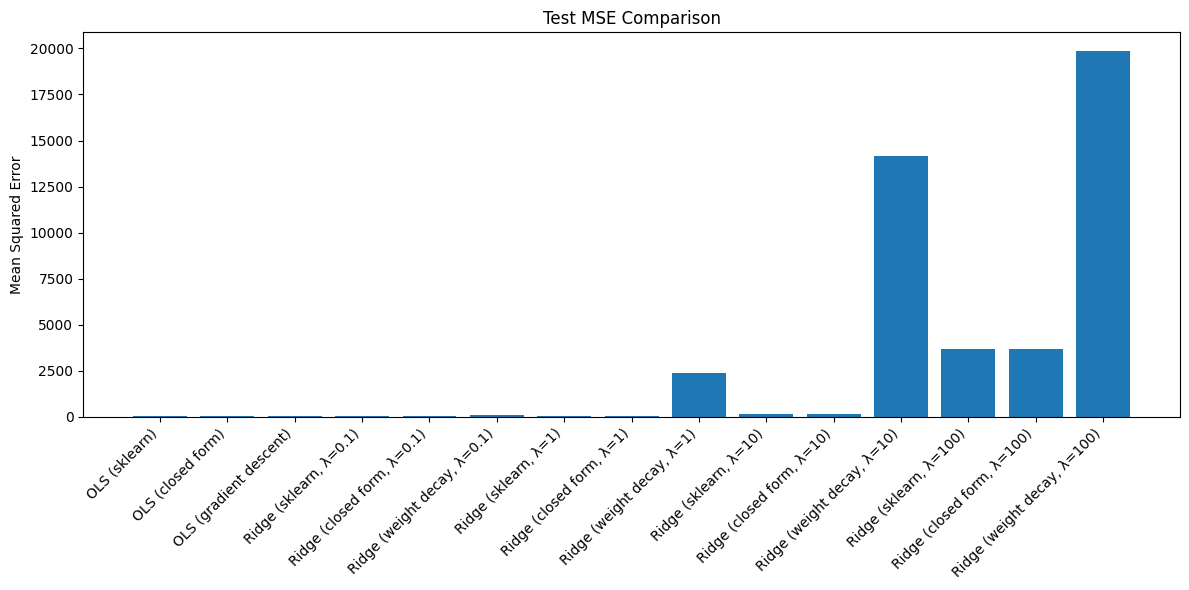

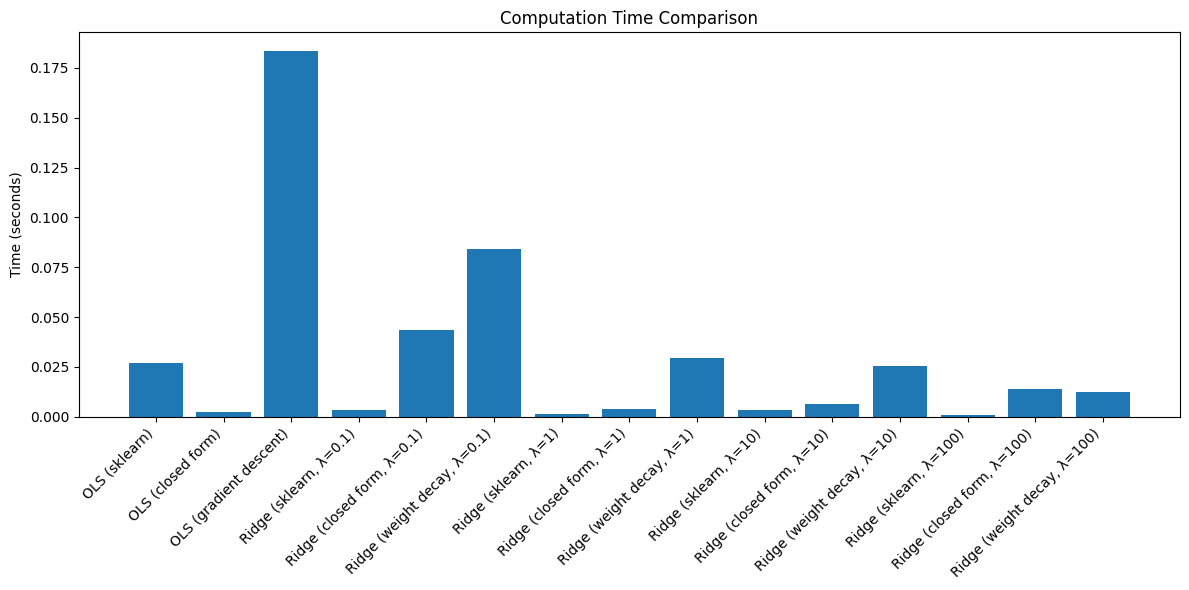

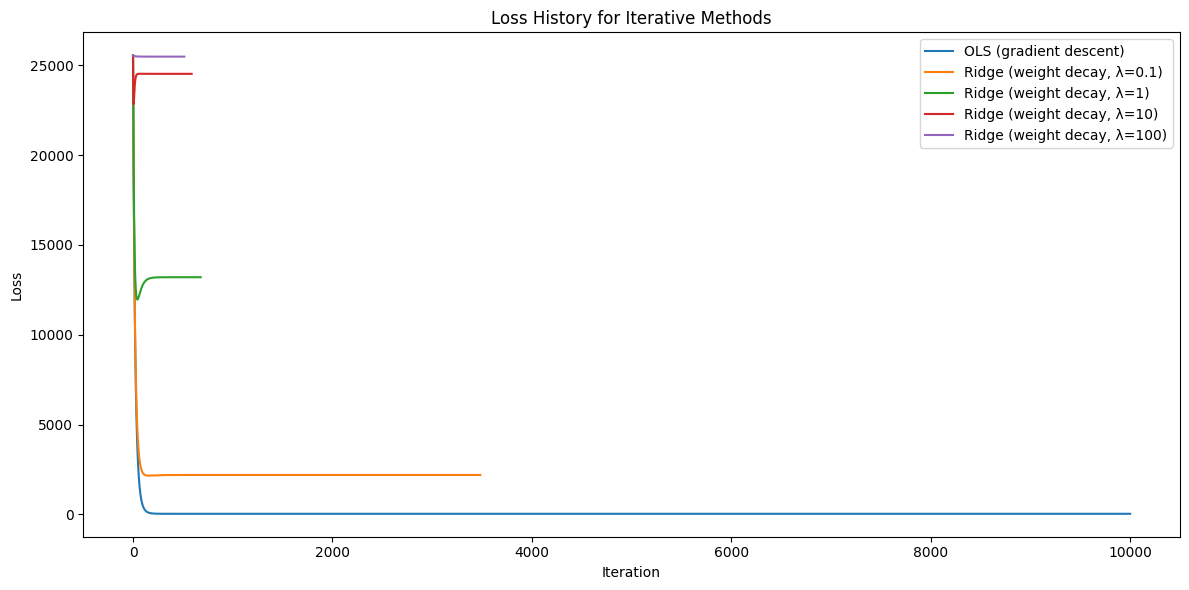

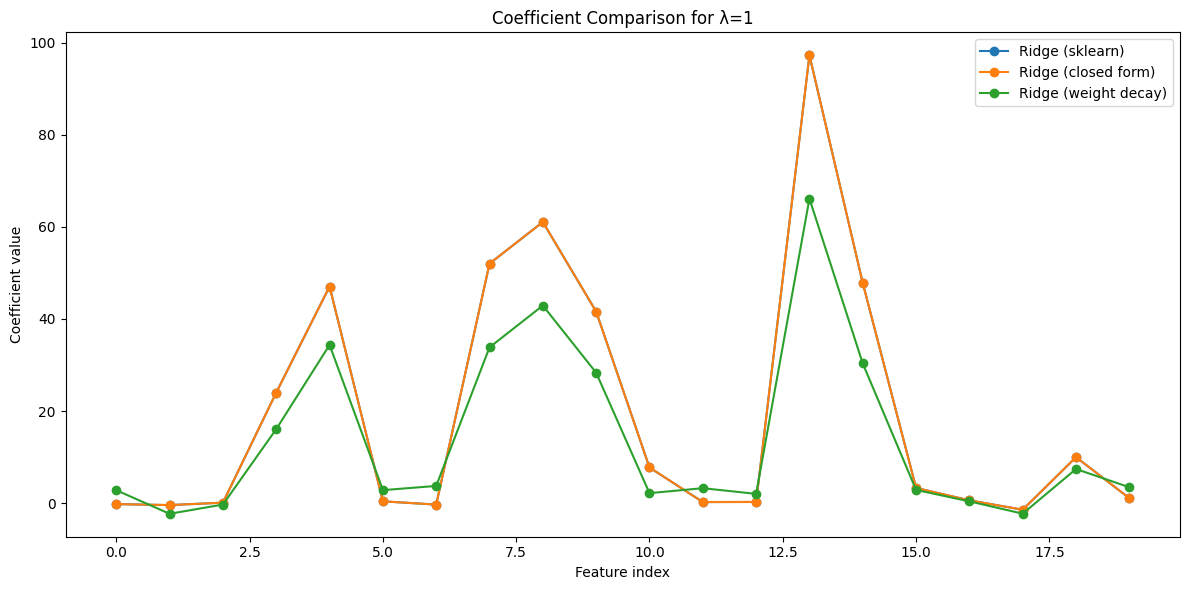


Coefficient similarity for λ=0.1: 0.999150
Mean absolute difference: 1.584178

Coefficient similarity for λ=1: 0.996138
Mean absolute difference: 7.375483

Coefficient similarity for λ=10: 0.977134
Mean absolute difference: 15.489881

Coefficient similarity for λ=100: 0.984555
Mean absolute difference: 12.351147


In [8]:
def main():
    # Generate data
    X_train, X_test, y_train, y_test = generate_data()
    
    # Compare methods
    results = compare_methods(X_train, X_test, y_train, y_test)
    
    # Print results
    print("\nTest MSE Results:")
    for method, result in results.items():
        if 'MSE' in result:
            print(f"{method}: {result['MSE']:.4f}")
    
    # Visualize results
    visualize_results(results, X_train, y_train)
    
    # Check coefficient similarity between Ridge and Weight Decay
    for lambda_ in [0.1, 1, 10, 100]:
        comparison_key = f'Coefficient comparison (λ={lambda_})'
        if comparison_key in results:
            coef_comparison = results[comparison_key]
            
            # Compute cosine similarity between Ridge (closed form) and Ridge (weight decay)
            ridge_coef = coef_comparison['Ridge (closed form)']
            wd_coef = coef_comparison['Ridge (weight decay)']
            
            similarity = np.dot(ridge_coef, wd_coef) / (np.linalg.norm(ridge_coef) * np.linalg.norm(wd_coef))
            
            print(f"\nCoefficient similarity for λ={lambda_}: {similarity:.6f}")
            print(f"Mean absolute difference: {np.mean(np.abs(ridge_coef - wd_coef)):.6f}")

if __name__ == "__main__":
    main()